In [193]:
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%pip install diffprivlib
%pip install seaborn

import math
import sklearn
import warnings
import numpy as np
import pandas as pd
import diffprivlib as dp
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

from diffprivlib.models import LogisticRegression as diff_LogisticRegression
from diffprivlib.tools.utils import mean, var
from diffprivlib.models.k_means import KMeans as diff_KMeans

from src.attackfunctions import collect_attack_data

import seaborn as sns

warnings.filterwarnings("ignore")

# set a random seed
random_seed = "57643"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Load Dataset 

In [194]:
# datafram df to reference raw dataset 
df = pd.read_csv("pcos_dataset.csv", sep=",", engine='python')
# splitting the original data for the target and shadow models 
df_target, df_shadow = train_test_split(df, test_size=0.5, random_state=58)
df

,Age,BMI,Menstrual_Irregularity,Testosterone_Level(ng/dL),Antral_Follicle_Count,PCOS_Diagnosis
0,24,34.7,1,25.2,20,0
1,37,26.4,0,57.1,25,0
2,32,23.6,0,92.7,28,0
3,28,28.8,0,63.1,26,0
4,25,22.1,1,59.8,8,0
...,...,...,...,...,...,...
995,34,18.4,1,95.7,23,0
996,45,28.9,1,28.5,7,0
997,37,28.3,0,32.4,28,0
998,41,27.3,0,95.6,9,0


## Preprocessing

### Test & Training Data split

In [195]:
# randomly select 50% data using random_seed for target set, rest in test 
D_target = df_shadow.sample(frac=0.5, random_state=int(random_seed))
D_test = df_shadow.drop(D_target.index)

In [196]:
target_variable = "PCOS_Diagnosis"
# columns that are not PCOS_Diagnosis will be feature/predictor columns 
feature_cols = [key for key in df.keys() if key != "PCOS_Diagnosis"]

## Logisitic Regression Target Model Training 

In [197]:
# model training
M_target = LogisticRegression(random_state=int(random_seed))
M_target.fit(D_target[feature_cols], D_target[target_variable])

# cross-validation evaluation
cv_results = cross_validate(M_target, D_target[feature_cols], D_target[target_variable], cv=5, scoring=['accuracy','precision','recall'])
average_accuracy = np.average(cv_results['test_accuracy'])
average_precision = np.average(cv_results['test_precision'])
average_recall= np.average(cv_results['test_recall'])

print(f"Average accuracy: {average_accuracy}")
print(f"Average precision: {average_precision}")
print(f"Average recall: {average_recall}")


Average accuracy: 0.9199999999999999
Average precision: 0.8428571428571429
Average recall: 0.6888888888888889


Confusion Matrix:
 [[198   3]
 [ 18  31]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95       201
           1       0.91      0.63      0.75        49

    accuracy                           0.92       250
   macro avg       0.91      0.81      0.85       250
weighted avg       0.92      0.92      0.91       250



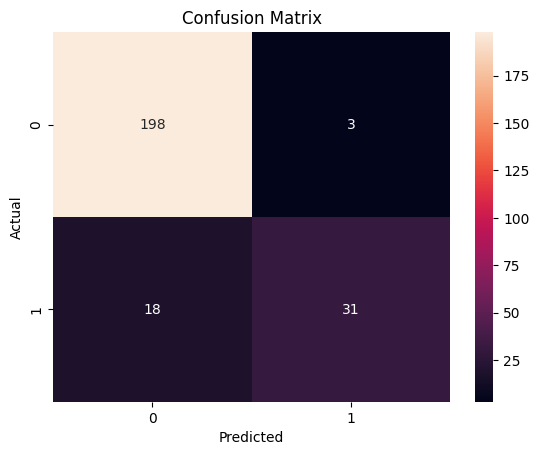

In [198]:
# using the trained model on test data
PCOS_diagonsis_predicted = pd.DataFrame(M_target.predict(D_test[feature_cols]))

# comparing with the ground truth and grab accuracy, precision, and revall
PCOS_diagonis_ground_truth = D_test[['PCOS_Diagnosis']] 
cm = confusion_matrix(PCOS_diagonis_ground_truth, PCOS_diagonsis_predicted)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(PCOS_diagonis_ground_truth, PCOS_diagonsis_predicted))

# visualizing results
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [199]:
# printing the predicted and ground truth 
print(PCOS_diagonsis_predicted)
print(PCOS_diagonis_ground_truth)

     0
0    1
1    0
2    0
3    0
4    0
..  ..
245  1
246  0
247  0
248  0
249  0

[250 rows x 1 columns]
     PCOS_Diagnosis
595               1
826               0
656               0
485               0
294               0
..              ...
722               1
406               1
751               0
578               0
74                0

[250 rows x 1 columns]


Confusion Matrix:
 [[198   3]
 [ 18  31]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95       201
           1       0.91      0.63      0.75        49

    accuracy                           0.92       250
   macro avg       0.91      0.81      0.85       250
weighted avg       0.92      0.92      0.91       250



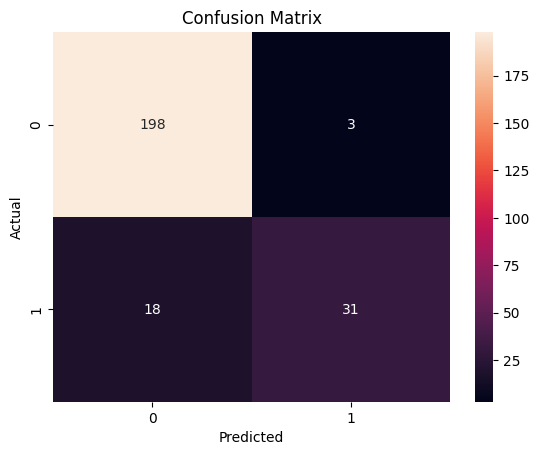

In [200]:
# Differential privacy 

# Train Target model
M_target = diff_LogisticRegression(epsilon=5).fit(D_target[feature_cols], D_target[target_variable])

# 1. Query the target model using the test dataset
PCOS_diagonsis_predicted_predicted = pd.DataFrame(M_target.predict(D_test[feature_cols]))
PCOS_diagonsis_predicted

# 2. Get now compare with the ground truth and grab accuracy, precision, and revall
PCOS_diagonis_ground_truth = D_test[['PCOS_Diagnosis']] 
cm = confusion_matrix(PCOS_diagonis_ground_truth, PCOS_diagonsis_predicted)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(PCOS_diagonis_ground_truth, PCOS_diagonsis_predicted))

# 3. Let's visualize some results
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [201]:
# 3. Test results
accuracy = accuracy_score(PCOS_diagonis_ground_truth, PCOS_diagonsis_predicted)
precision = precision_score(PCOS_diagonis_ground_truth, PCOS_diagonsis_predicted)
recall = recall_score(PCOS_diagonis_ground_truth, PCOS_diagonsis_predicted)

print(f"Accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")

Accuracy: 0.916
precision: 0.9117647058823529
recall: 0.6326530612244898


## Random Forest Target Model

In [202]:
# model training
M_target2 = RandomForestClassifier(n_estimators=100,random_state=int(random_seed))
M_target2.fit(D_target[feature_cols], D_target[target_variable])

# cross-validation evaluation
cv_results = cross_validate(M_target2, D_target[feature_cols], D_target[target_variable], cv=5, scoring=['accuracy','precision','recall'])
average_accuracy = np.average(cv_results['test_accuracy'])
average_precision = np.average(cv_results['test_precision'])
average_recall= np.average(cv_results['test_recall'])

print(f"Average accuracy: {average_accuracy}")
print(f"Average precision: {average_precision}")
print(f"Average recall: {average_recall}")

Average accuracy: 0.984
Average precision: 1.0
Average recall: 0.9111111111111111


Confusion Matrix:
 [[201   0]
 [  0  49]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       201
           1       1.00      1.00      1.00        49

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



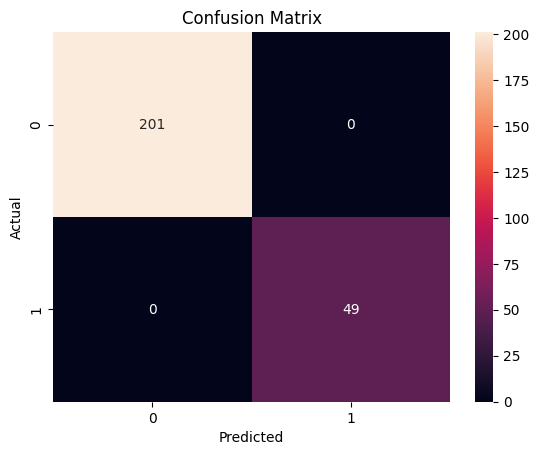

In [203]:
# using the trained model on test data
PCOS_diagonsis_predicted = pd.DataFrame(M_target2.predict(D_test[feature_cols]))

# comparing with the ground truth and grab accuracy, precision, and revall
PCOS_diagonis_ground_truth = D_test[['PCOS_Diagnosis']] 
cm = confusion_matrix(PCOS_diagonis_ground_truth, PCOS_diagonsis_predicted)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(PCOS_diagonis_ground_truth, PCOS_diagonsis_predicted))

# visualizing results
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Shadow Models

### Split the data and train 3 shadow models for each

In [204]:
# splitting the test/train data for shadow model 1 
D_shadow1_target = df_shadow.sample(frac=0.5, random_state=1)
D_shadow1_test = df_shadow.drop(D_shadow1_target.index)

# lr shadow model training
M_lrshadow1 = LogisticRegression(random_state=int(random_seed))
M_lrshadow1.fit(D_shadow1_target[feature_cols], D_shadow1_target[target_variable])
# rf shadow model training 
M_rfshadow1 = RandomForestClassifier(n_estimators=100,random_state=int(random_seed))
M_rfshadow1.fit(D_shadow1_target[feature_cols], D_shadow1_target[target_variable])

# splitting the test/train data for shadow model 2
D_shadow2_target = df_shadow.sample(frac=0.5, random_state=2)
D_shadow2_test = df_shadow.drop(D_shadow2_target.index)
# lr shadow model training
M_lrshadow2 = LogisticRegression(random_state=int(random_seed))
M_lrshadow2.fit(D_shadow2_target[feature_cols], D_shadow2_target[target_variable])
# rf shadow model training 
M_rfshadow2 = RandomForestClassifier(n_estimators=100,random_state=int(random_seed))
M_rfshadow2.fit(D_shadow2_target[feature_cols], D_shadow2_target[target_variable])

# splitting the test/train data for shadow model 3
D_shadow3_target = df_shadow.sample(frac=0.5, random_state=3)
D_shadow3_test = df_shadow.drop(D_shadow3_target.index)
# lr shadow model 
M_lrshadow3 = LogisticRegression(random_state=int(random_seed))
M_lrshadow3.fit(D_shadow3_target[feature_cols], D_shadow3_target[target_variable])
# rf shadow model training 
M_rfshadow3 = RandomForestClassifier(n_estimators=100,random_state=int(random_seed))
M_rfshadow3.fit(D_shadow3_target[feature_cols], D_shadow3_target[target_variable])


RandomForestClassifier(random_state=57643)

## Attack Model

### Black-Box 

In [205]:
# predictions from lr target model 
lrtarget_train_preds = M_target.predict_proba(D_target[feature_cols])
lrtarget_test_preds = M_target.predict_proba(D_test[feature_cols])
# lr target model's outputs from train & test stacked 
X_attack_eval1 = np.vstack([lrtarget_train_preds, lrtarget_test_preds])
y_attack_eval1 = np.array([1]*len(lrtarget_train_preds) + [0]*len(lrtarget_test_preds))

# predictions from rf target model 
rftarget_train_preds2 = M_target2.predict_proba(D_target[feature_cols])
rftarget_test_preds2 = M_target2.predict_proba(D_test[feature_cols])
# rf target model's outputs from train & test stacked
X_attack_eval2 = np.vstack([rftarget_train_preds2, rftarget_test_preds2])
y_attack_eval2 = np.array([1]*len(rftarget_train_preds2) + [0]*len(rftarget_test_preds2))


### Logistic Regression Attack

In [206]:
# collecting predictions from lr shadow models 
X1, y1 = collect_attack_data(M_lrshadow1, D_shadow1_target, D_shadow1_test, feature_cols, target_variable)
X2, y2 = collect_attack_data(M_lrshadow2, D_shadow2_target, D_shadow2_test, feature_cols, target_variable)
X3, y3 = collect_attack_data(M_lrshadow3, D_shadow3_target, D_shadow3_test, feature_cols, target_variable)
# combining lr shadow model results into one 
x_totalattack = np.vstack([X1, X2, X3])
y_totalattack = np.hstack([y1, y2, y3])
# lr attack model 
M_lrattack = LogisticRegression(random_state=int(random_seed))
M_lrattack.fit(x_totalattack, y_totalattack)

# evaluating 
cv_results = cross_validate(M_lrattack, X_attack_eval1, y_attack_eval1, cv=5, scoring=['accuracy','precision','recall'])
average_accuracy = np.average(cv_results['test_accuracy'])
average_precision = np.average(cv_results['test_precision'])
average_recall= np.average(cv_results['test_recall'])

print(f"Average accuracy: {average_accuracy}")
print(f"Average precision: {average_precision}")
print(f"Average recall: {average_recall}")

Average accuracy: 0.46799999999999997
Average precision: 0.46998051948051944
Average recall: 0.296


### Random Forest Attack 

In [207]:
# collect predictiona from rf shadow model 
X1, y1 = collect_attack_data(M_rfshadow1, D_shadow1_target, D_shadow1_test, feature_cols, target_variable)
X2, y2 = collect_attack_data(M_rfshadow2, D_shadow2_target, D_shadow2_test, feature_cols, target_variable)
X3, y3 = collect_attack_data(M_rfshadow3, D_shadow3_target, D_shadow3_test, feature_cols, target_variable)
# combining rf shadow model results into one 
x_attack = np.vstack([X1, X2, X3])
y_attack = np.hstack([y1, y2, y3])
# rf attack model 
M_rfattack = RandomForestClassifier(n_estimators=100,random_state=int(random_seed))
M_rfattack.fit(x_attack, y_attack)

# evaluating 
cv_results = cross_validate(M_rfattack, X_attack_eval2, y_attack_eval2, cv=5, scoring=['accuracy','precision','recall'])
average_accuracy = np.average(cv_results['test_accuracy'])
average_precision = np.average(cv_results['test_precision'])
average_recall= np.average(cv_results['test_recall'])

print(f"Average accuracy: {average_accuracy}")
print(f"Average precision: {average_precision}")
print(f"Average recall: {average_recall}")


Average accuracy: 0.5800000000000001
Average precision: 0.5610683133173422
Average recall: 0.74


In [208]:
# running lr attack
lrattack_preds = M_lrattack.predict(X_attack_eval1)
# evaluation
print("Logisitc Regression Attack Model Performance:")
print(classification_report(y_attack_eval1, lrattack_preds))

# running rf attack
rfattack_preds = M_rfattack.predict(X_attack_eval2)
# evaluation
print("Random Forest Attack Model Performance:")
print(classification_report(y_attack_eval2, rfattack_preds))

Logisitc Regression Attack Model Performance:
              precision    recall  f1-score   support

           0       0.51      0.80      0.63       250
           1       0.55      0.24      0.34       250

    accuracy                           0.52       500
   macro avg       0.53      0.52      0.48       500
weighted avg       0.53      0.52      0.48       500

Random Forest Attack Model Performance:
              precision    recall  f1-score   support

           0       0.66      0.45      0.53       250
           1       0.58      0.77      0.66       250

    accuracy                           0.61       500
   macro avg       0.62      0.61      0.60       500
weighted avg       0.62      0.61      0.60       500

